# LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from torch.nn.utils.rnn import pad_sequence

In [2]:
# === Set random seed ===
np.random.seed(691)

In [3]:
# === Load data ===
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/validation.csv")
test_df = pd.read_csv("data/test.csv")# Feature columns
feature_cols = ['statement', 'subject', 'speaker', 'party_affiliation', 'context',
       'subject_count', 'readability_score', 'num_named_entities',
       'entity_types_present', 'has_citation_words',
       'polarity_shift_words_count', 'uncertainty_words_count',
       'negation_words_count', 'tfidf_score_sum', 'sentiment_score']

numeric_cols = ['subject_count', 'readability_score', 'num_named_entities',
                'entity_types_present', 'has_citation_words',
                'polarity_shift_words_count', 'uncertainty_words_count',
                'negation_words_count', 'tfidf_score_sum', 'sentiment_score']

categorical_cols = ['subject', 'speaker', 'party_affiliation', 'context']
target_col = 'label_id'

In [4]:
# === Tokenization + vocab ===
def tokenize(text):
    return text.lower().split()

counter = Counter()
for text in train_df["statement"]:
    tokens = tokenize(text)
    counter.update(tokens)

vocab = {word: idx + 2 for idx, (word, _) in enumerate(counter.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode(text):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokenize(text)]

In [5]:
# === Load GloVe embeddings ===
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load GloVe
glove_dim = 100
glove_path = 'data/glove/glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_path)

# Build embedding matrix
embedding_matrix = np.zeros((len(vocab), glove_dim))
for word, idx in vocab.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embedding_matrix[idx] = vector
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(glove_dim,))

In [6]:
# === Encode categorical ===
cat_encoders = {}
num_categorical_feats_list = []
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([train_df[col], val_df[col], test_df[col]]).astype(str))
    cat_encoders[col] = le
    num_categorical_feats_list.append(len(le.classes_))

In [7]:
# === Scale numeric ===
scaler = StandardScaler()
scaler.fit(train_df[numeric_cols])
train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

In [8]:
# === Dataset and Dataloader ===
class LIARDataset(Dataset):
    def __init__(self, df, numeric_cols, cat_encoders):
        self.texts = [torch.tensor(encode(text)) for text in df["statement"]]
        self.labels = torch.tensor(df[target_col].values, dtype=torch.long)
        
        self.numeric_feats = torch.tensor(df[numeric_cols].values, dtype=torch.float32)
        
        self.categorical_feats = []
        for col, encoder in cat_encoders.items():
            encoded_col = encoder.transform(df[col].astype(str))
            self.categorical_feats.append(torch.tensor(encoded_col, dtype=torch.long))
        self.categorical_feats = torch.stack(self.categorical_feats, dim=1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': self.texts[idx],
            'numeric_feats': self.numeric_feats[idx],
            'categorical_feats': self.categorical_feats[idx],
            'label': self.labels[idx]
        }

def collate_fn(batch):
    texts = [item['text'] for item in batch]
    numeric_feats = torch.stack([item['numeric_feats'] for item in batch])
    categorical_feats = torch.stack([item['categorical_feats'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=vocab["<PAD>"])
    
    return padded_texts, numeric_feats, categorical_feats, labels

batch_size = 64
train_loader = DataLoader(LIARDataset(train_df, numeric_cols, cat_encoders),
                          batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(LIARDataset(val_df, numeric_cols, cat_encoders),
                        batch_size=batch_size, collate_fn=collate_fn)
test_loader = DataLoader(LIARDataset(test_df, numeric_cols, cat_encoders),
                         batch_size=batch_size, collate_fn=collate_fn)

In [9]:
# === Model ===
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, num_classes,
                 num_numeric_feats, num_categorical_feats_list, cat_embed_dim=16):
        super().__init__()
        
        vocab_size, embed_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<PAD>"])
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = True
        
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_size, cat_embed_dim) for cat_size in num_categorical_feats_list
        ])
        
        total_input_dim = hidden_dim + num_numeric_feats + len(num_categorical_feats_list) * cat_embed_dim
        
        self.fc = nn.Sequential(
            nn.Linear(total_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, text, numeric_feats, categorical_feats):
        embedded = self.embedding(text)
        _, (h_n, _) = self.lstm(embedded)
        lstm_out = h_n.squeeze(0)
        
        cat_embeds = []
        for i, embedding_layer in enumerate(self.cat_embeddings):
            cat_embed = embedding_layer(categorical_feats[:, i])
            cat_embeds.append(cat_embed)
        cat_embeds = torch.cat(cat_embeds, dim=1)
        
        combined = torch.cat([lstm_out, numeric_feats, cat_embeds], dim=1)
        
        output = self.fc(combined)
        return output

In [10]:
# === Training setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = train_df[target_col].nunique()
model = LSTMClassifier(
    embedding_matrix=embedding_matrix,
    hidden_dim=128,
    num_classes=num_classes,
    num_numeric_feats=len(numeric_cols),
    num_categorical_feats_list=num_categorical_feats_list,
    cat_embed_dim=16
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss()

Using device: cuda


In [11]:
# === Training loop with early stopping + scheduler ===
num_epochs = 100
early_stop_patience = 5
best_val_loss = np.inf
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for text_batch, numeric_batch, categorical_batch, label_batch in train_loader:
        text_batch = text_batch.to(device)
        numeric_batch = numeric_batch.to(device)
        categorical_batch = categorical_batch.to(device)
        label_batch = label_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(text_batch, numeric_batch, categorical_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    
    # === Evaluate on validation set ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for text_batch, numeric_batch, categorical_batch, label_batch in val_loader:
            text_batch = text_batch.to(device)
            numeric_batch = numeric_batch.to(device)
            categorical_batch = categorical_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(text_batch, numeric_batch, categorical_batch)
            loss = criterion(outputs, label_batch)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Validation loss improved, resetting early stop counter.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss. Early stop counter: {epochs_no_improve}/{early_stop_patience}")
        
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered!")
            break

Epoch 1/100 | Train Loss: 1.7686 | Val Loss: 1.7476
Validation loss improved, resetting early stop counter.
Epoch 2/100 | Train Loss: 1.7440 | Val Loss: 1.7372
Validation loss improved, resetting early stop counter.
Epoch 3/100 | Train Loss: 1.7351 | Val Loss: 1.7284
Validation loss improved, resetting early stop counter.
Epoch 4/100 | Train Loss: 1.7281 | Val Loss: 1.7241
Validation loss improved, resetting early stop counter.
Epoch 5/100 | Train Loss: 1.7213 | Val Loss: 1.7187
Validation loss improved, resetting early stop counter.
Epoch 6/100 | Train Loss: 1.7148 | Val Loss: 1.7176
Validation loss improved, resetting early stop counter.
Epoch 7/100 | Train Loss: 1.7114 | Val Loss: 1.7150
Validation loss improved, resetting early stop counter.
Epoch 8/100 | Train Loss: 1.7053 | Val Loss: 1.7129
Validation loss improved, resetting early stop counter.
Epoch 9/100 | Train Loss: 1.7028 | Val Loss: 1.7094
Validation loss improved, resetting early stop counter.
Epoch 10/100 | Train Loss: 1

In [12]:
# === Final Evaluation ===
def evaluate(model, dataloader, split_name):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for text_batch, numeric_batch, categorical_batch, label_batch in dataloader:
            text_batch = text_batch.to(device)
            numeric_batch = numeric_batch.to(device)
            categorical_batch = categorical_batch.to(device)
            label_batch = label_batch.to(device)
            
            outputs = model(text_batch, numeric_batch, categorical_batch)
            preds = torch.argmax(outputs, dim=1)
            
            all_labels.extend(label_batch.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    print(f"\n{split_name} Classification Report:\n")
    print(classification_report(all_labels, all_preds))
    
    cm = confusion_matrix(all_labels, all_preds)
    label_names = train_df[['label_id', 'label']].drop_duplicates().sort_values('label_id')['label'].tolist()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names,
                yticklabels=label_names)
    
    plt.title(f'Confusion Matrix ({split_name})', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()


Validation Set Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.26      0.36       116
           1       0.28      0.47      0.35       263
           2       0.22      0.14      0.17       237
           3       0.28      0.23      0.25       248
           4       0.29      0.45      0.36       251
           5       0.20      0.07      0.10       169

    accuracy                           0.29      1284
   macro avg       0.31      0.27      0.26      1284
weighted avg       0.29      0.29      0.27      1284



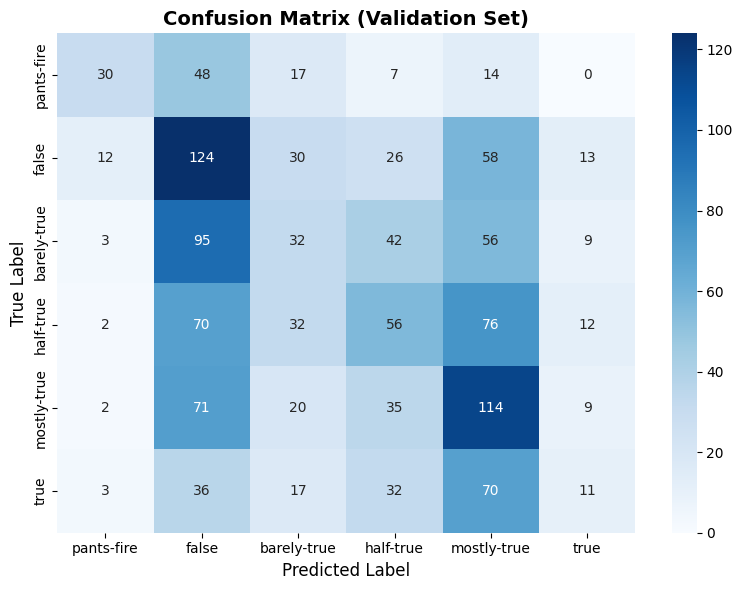


Test Set Classification Report:

              precision    recall  f1-score   support

           0       0.33      0.15      0.21        92
           1       0.25      0.44      0.32       249
           2       0.24      0.15      0.19       212
           3       0.26      0.20      0.23       265
           4       0.25      0.40      0.31       241
           5       0.21      0.07      0.10       208

    accuracy                           0.25      1267
   macro avg       0.26      0.24      0.23      1267
weighted avg       0.25      0.25      0.23      1267



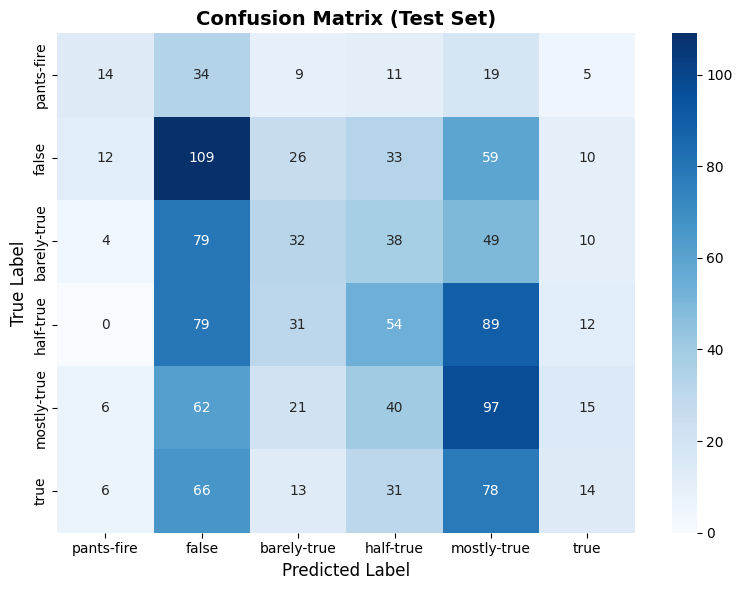

In [13]:
# === Load best model and evaluate ===
model.load_state_dict(torch.load("best_model.pt"))
evaluate(model, val_loader, "Validation Set")
evaluate(model, test_loader, "Test Set")